In [1]:
import json
from collections import defaultdict
from operator import itemgetter
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
import re
import os
import tqdm
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from prettytable import PrettyTable

In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

In [3]:
# folder of data
DATA_FOLDER = '../content'
# folder of processed data
PROCESSED_DATA_FOLDER = '../content/processed_data'
# path image format
IMAGE_FORMAT = '../content/%s/COCO_%s_%012d.jpg'

# top most frequent answers
MAX_ANSWERS = 1000 
# batch size
BATCH_SIZE = 300
# buffer size
BUFFER_SIZE = 5000

In [4]:
"""
    Annotation Format
    
    annotation{
    "question_id" : int,
    "image_id" : int,
    "question_type" : str,
    "answer_type" : str,
    "answers" : [answer],
    "multiple_choice_answer" : str
    }
    
    answer{
    "answer_id" : int,
    "answer" : str,
    "answer_confidence": str
    }
"""
# training annotations
tTrainAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_train2014_annotations.json', 'r'))
# validation annotations
tValAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_val2014_annotations.json', 'r'))

"""
    Input Questions Format
    
    question{
    "question_id" : int,
    "image_id" : int,
    "question" : str
}

"""
# training questions
tTrainQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
# validation questions
tValQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_val2014_questions.json', 'r'))
# test questions
tTestQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_test2015_questions.json', 'r'))

In [5]:
# Display the 2 first annotations
tTrainAnnotations['annotations'][:2]

[{'question_type': 'what is this',
  'multiple_choice_answer': 'net',
  'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
   {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
   {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
  'image_id': 458752,
  'answer_type': 'other',
  'question_id': 458752000},
 {'question_type': 'what',
  'multiple_choice_answer': 'pitcher',
  'answers': [{'answer': 'pitcher',
    'answer_confidence': 'yes',
    'answer_id': 1},
   {'answer': 'c

In [6]:
"""
    Function name: GetAllAnswer
    
    Objective: Join a list of answers by ";" to a single string
    
    Summary algorithmic description: Return a list of answers
    
    Input parameters: clAnswers: list of dictionaries of answers
    
    Return : list of answers of a question
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def GetAllAnswer(clAnswers):
    return ';'.join([cdAnswer['answer'] for cdAnswer in clAnswers])

In [7]:
"""
    Function name: ProcessQuestionAnnotation
    
    Objective: Creates a JSON file whose elements are (img_path, question, ans, answers)
    
    Summary algorithmic description: Loop over all annotations to read all elements
                                     Add every element to the list
                                     Save the list to a JSON file
    
    Input parameters: sDataFolder: "train2014" or "val2014"
    
    Return : None
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessQuestionAnnotation(sDataFolder):
    # Read input annotation data
    tAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_{sDataFolder}_annotations.json', 'r'))
    # Read input question data
    tQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_{sDataFolder}_questions.json', 'r'))
    # list of dictionaries whose keys are (img_path, question, ans, answers)
    clData = []

    # Loop over all annotations
    for iC in tqdm.tqdm(range(len(tAnnotations['annotations']))):
        # path image
        sImagePath = IMAGE_FORMAT%(sDataFolder, sDataFolder, tAnnotations['annotations'][iC]['image_id'])
        # question
        sQuestion = tQuestions['questions'][iC]['question']
        # answer
        sAns = tAnnotations['annotations'][iC]['multiple_choice_answer']
        # list of answers
        clAnswers = GetAllAnswer(tAnnotations['annotations'][iC]['answers'])
        # Add a element to the dictionary
        clData.append({'img_path': sImagePath, 'question': sQuestion, 'ans': sAns, 'answers': clAnswers})
    
    # save to disk
    json.dump(clData, open(f'{DATA_FOLDER}/vqa_raw_{sDataFolder}.json', 'w'))

In [8]:
# Creates a JSON file whose elements are (img_path, question, ans, answers) for train data
ProcessQuestionAnnotation("train2014")
# Creates a JSON file whose elements are (img_path, question, ans, answers) for val data
ProcessQuestionAnnotation("val2014")

100%|██████████| 214354/214354 [00:00<00:00, 377728.13it/s]


In [9]:
# Read training data
tTrainData = json.load(open(f'{DATA_FOLDER}/vqa_raw_train2014.json', 'r'))
# Read validation data
tValData = json.load(open(f'{DATA_FOLDER}/vqa_raw_val2014.json', 'r'))

In [10]:
# training and validation data 
tTrainValData = tTrainData + tValData

In [11]:
# Display the 5 first lines
tTrainValData[:5]

[{'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What is this photo taken looking through?',
  'ans': 'net',
  'answers': 'net;net;net;netting;net;net;mesh;net;net;net'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What position is this man playing?',
  'ans': 'pitcher',
  'answers': 'pitcher;catcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What color is the players shirt?',
  'ans': 'orange',
  'answers': 'orange;orange;orange;orange;orange;orange;orange;orange;orange;orange'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'Is this man a professional baseball player?',
  'ans': 'yes',
  'answers': 'yes;yes;yes;yes;yes;no;yes;yes;yes;yes'},
 {'img_path': '../content/train2014/COCO_train2014_000000262146.jpg',
  'question': 'What color is the snow?',
  'ans': 'whit

In [12]:
print("Length of train dataset: ", len(tTrainData))
print("Length of validation dataset: ", len(tValData))
print("Length of train + val dataset: ", len(tTrainValData))

Length of train dataset:  443757
Length of validation dataset:  214354
Length of train + val dataset:  658111


# Reduce dataset to top 1000 answers

In [13]:
# dictionary with key is a answer and value is number of this answer in the dataset
cdAnswerFreq = defaultdict(int)
# Loop over all answers in the trainning + validation data
for sAnswer in list(map(itemgetter('ans'), tTrainValData)):
    # number of this answer (sAnswer) inscrease
    cdAnswerFreq[sAnswer] += 1

# list of top 1000 most frequents answers as a tuple (answer, frequency)   
clSortedFreq = sorted(cdAnswerFreq.items(), key=itemgetter(1), reverse=True)[0: MAX_ANSWERS]
# Produce tuples of top 1000 most frequents answers and top 1000 most frequencies
ctTopAnswer, ctTopFreq = zip(*clSortedFreq)

In [14]:
# Display number of different types of answers
print('There are total ', len(cdAnswerFreq), ' different types of answers.')

There are total  29332  different types of answers.


In [15]:
# answer frequency table
oAnswerFrequencyTable = PrettyTable(["Answer Type", "Answer Count", "Coverage(%)"])

for iC in range(10):
    # Row of table
    clRow = []
    # Answer Type
    clRow.append(ctTopAnswer[iC])
    # Answer Count
    clRow.append(ctTopFreq[iC])
    # Coverage of this answer
    clRow.append(np.round((ctTopFreq[iC]/sum(ctTopFreq))*100, 2))
    # Add this row
    oAnswerFrequencyTable.add_row(clRow)

# Print answer frequency table
print(oAnswerFrequencyTable)

+-------------+--------------+-------------+
| Answer Type | Answer Count | Coverage(%) |
+-------------+--------------+-------------+
|     yes     |    125706    |    21.87    |
|      no     |    122598    |    21.32    |
|      1      |    18633     |     3.24    |
|      2      |    17960     |     3.12    |
|    white    |    13227     |     2.3     |
|      3      |     9609     |     1.67    |
|     blue    |     8188     |     1.42    |
|     red     |     7684     |     1.34    |
|    black    |     7578     |     1.32    |
|      0      |     7323     |     1.27    |
+-------------+--------------+-------------+


In [16]:
"""
    Function name: SelectTopAnswersData
    
    Objective: Reduces the dataset to contain only the datapoints whose answer occurence is in top most frequents 
    
    Summary algorithmic description: Find the top most frequents answers
                                     Get all the datapoints whose answer occurence is in top most frequents 
    
    Input parameters: clQuestion: list of questions
                      clMostFreqAnswer : list of most frequent answer of a question
                      clAnswers : list of all possible answers of a question
                      clPathImage : list of path images
                      iNbTopAnswers : number of top answers 
    
    Return : tuple of reduced dataset and the top k answers
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def SelectTopAnswersData(clQuestion, clMostFreqAnswer, clAnswers, clPathImage, iNbTopAnswers):
    # dictionary with key is a answer and value is number of this answer in the dataset
    cdAnswerFreq= defaultdict(int)
    
    # Loop over all the most frequent answers of a image in the dataset
    for sAnswer in clMostFreqAnswer:
        # number of this answer (sAnswer) inscrease
        cdAnswerFreq[sAnswer] += 1

    # list of top most frequents answers as a tuple (answer, frequency) 
    cdSortedAnswerFreq = sorted(cdAnswerFreq.items(), key=itemgetter(1), reverse=True)[0: iNbTopAnswers]
    # Produce tuples of top most frequents answers and top most frequencies
    ctTopAnswer, ctTopFreqAnswer = zip(*cdSortedAnswerFreq)

    # list of questions whose answer is in the top most frequent answers
    clNewQuestion = []
    # list of top most frequents answers
    clNewMostFreqAnswer = []
    # list of all possible answers of a question whost the most frequent answer is in the top most frequent answers
    clNewAnswers = []
    # list of images whose answer is in the top most frequent answers
    clNewPathImage = []

    # Loop over all elements
    for sQuestion, sMostFreqAnswer, clAnswer, sPathImage in zip(clQuestion, clMostFreqAnswer, clAnswers, clPathImage):
        # if the most frequent answer of a image is in the top most frequents answers
        if sMostFreqAnswer in ctTopAnswer:
            # Add the question to the list
            clNewQuestion.append(sQuestion)
            # Add the most frequent answer of a image to the list
            clNewMostFreqAnswer.append(sMostFreqAnswer)
            # Add all possible answers of a question to the list
            clNewAnswers.append(clAnswer)
            # Add the path image to the list
            clNewPathImage.append(sPathImage)

    # Amount of data reduction 
    print('Data size reduced by', np.round(((len(clQuestion) - len(clNewQuestion)) / len(clQuestion)) * 100, 2), '%')
    # Return tuple of reduced dataset and the top k answers
    return(clNewQuestion, clNewMostFreqAnswer, clNewAnswers, clNewPathImage, ctTopAnswer)

In [18]:
# Reduce the train + val dataset to contain only the datapoints whose answer occurence is in top most frequents
clQuestionTrainVal, clAnswerTrainVal, clAnswersTrainVal, clPathImageTrainVal, ctTopAnswer = \
SelectTopAnswersData(list(map(itemgetter('question'), tTrainValData)), 
                    list(map(itemgetter('ans'), tTrainValData)), 
                    list(map(itemgetter('answers'), tTrainValData)), 
                    list(map(itemgetter('img_path'), tTrainValData)), 
                    MAX_ANSWERS)

Data size reduced by 12.64 %


In [19]:
# save reduced training + validation data to disk
with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_trainVal2014_top1000.json', 'wb') as f:
    joblib.dump((clQuestionTrainVal, clAnswerTrainVal, clAnswersTrainVal, clPathImageTrainVal), f)

In [20]:
# load reduced training + validation data from disk
with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_trainVal2014_top1000.json', 'rb') as f:
    clQuestionTrainVal, clAnswerTrainVal, clAnswersTrainVal, clPathImageTrainVal = joblib.load(f)

# Image features

In [21]:
"""
    Function name: ImageFeatureExtractor
    
    Objective: Extract (49, 512)-dimensional CNN features by fine-tuning VGG19 and save them locally 
    
    Summary algorithmic description: Load pre-trained model VGG19, don't add final layer
                                     Pass the pprecessed images through the network and use the outputs as our actual features
                                     Save image features to image id folder
    
    Input parameters: sImageFolder : image folder name
                      sPathFeature: path to save the features
                      clImageFilename : list of image filenames
                      iBatchSize : batch size
    
    Return : None
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ImageFeatureExtractor(sImageFolder, sPathFeature, clImageFilename, iBatchSize):
    # Load pre-trained model graph, don't add final layer
    model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

    # add a progress bar
    progbar = utils.Progbar(int(np.ceil(len(clImageFilename) / float(iBatchSize))))

    # loop over the images in batches
    for (iCounter, iBSize) in enumerate(range(0, len(clImageFilename), iBatchSize)):
        # extract batch of images and prepare them to pass it through the VGG 
        # network for feature extraction

        # Update the progress bar.
        progbar.update(iCounter+1)

        # range of batch
        itBatchRange = range(iBSize, min(iBSize + iBatchSize, len(clImageFilename)))
        # batch of image filenames
        clBatchImageFilename = clImageFilename[itBatchRange[0]: itBatchRange[-1]+1]

        # list of processed images
        clBatchImage = []
        # list of image ids 
        clBatchId = []
        # loop over the images in the current batch
        for sImageFilename in clBatchImageFilename:

            # load the input image, while ensuring the image is resized to 224x224 pixels
            img = image.load_img(f'{DATA_FOLDER}/{sImageFolder}/' + sImageFilename, target_size=(224, 224))
            # Convert a PIL Image instance to a Numpy array.
            caImg = image.img_to_array(img)

            # expand the dimensions to include batch dim
            caImg = np.expand_dims(caImg, axis=0)
            # The image are converted from RGB to BGR, then each color channel is zero-centered 
            # with respect to the ImageNet dataset, without scaling.
            caImg = preprocess_input(caImg)

            # add the image to the batch
            clBatchImage.append(caImg)
            # Add the image id of the batch to the list of ids
            clBatchId.append(sImageFilename.split('.')[0][-6:])

        # Stack image arrays in sequence vertically (BATCH_SIZE, 224, 224, 3)
        clBatchImage = np.vstack(clBatchImage) 

        # Pass the images through the network and use the outputs as our actual features (BATCH_SIZE, 7, 7, 512)
        tsFeatures = model.predict(clBatchImage) 
        # Reshapes the features (BATCH_SIZE, 49, 512)
        tsFeatures = tf.reshape(tsFeatures, (tsFeatures.shape[0], -1, tsFeatures.shape[-1])) 

        # Loop over the batch to save them locally
        for sId, tsFeature in zip(clBatchId, tsFeatures):
            # Save image features to image id folder 
            np.save(os.path.join(sPathFeature, sId), tsFeature)

In [28]:
# clImageFilenameTrain = os.listdir(f'{DATA_FOLDER}/train2014')

In [29]:
# ImageFeatureExtractor('train2014', f'{DATA_FOLDER}/features', clImageFilenameTrain, BATCH_SIZE)

In [38]:
# # list of all image filenames
# clImageFilenameVal = os.listdir(f'{DATA_FOLDER}/val2014')
# # Extract (49, 512)-dimensional CNN features by fine-tuning VGG19 and save them locally 
# ImageFeatureExtractor('val2014', f'{DATA_FOLDER}/features', clImageFilenameVal, BATCH_SIZE)

136/136 [==============================] - 6501s 48s/step


# Text features

In [22]:
# contraction mappings
CONTRACTIONS = {"aint": "ain't", "arent": "aren't", "cant": "can't", 
                "couldve": "could've", "couldnt": "couldn't", "couldn'tve": "couldn't've", "couldnt've": "couldn't've", 
                "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", 
                "hadnt": "hadn't", "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", 
                "hed": "he'd", "hed've": "he'd've", "he'dve": "he'd've", "hes": "he's", 
                "howd": "how'd", "howll": "how'll", "hows": "how's", 
                "Id've": "I'd've", "I'dve": "I'd've", "Im": "I'm", "Ive": "I've", 
                "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", 
                "let's": "let's", 
                "maam": "ma'am", 
                "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", 
                "mustnt": "mustn't", "mustve": "must've", 
                "neednt": "needn't", "notve": "not've", 
                "oclock": "o'clock", 
                "oughtnt": "oughtn't", 
                "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", 
                "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", "she's": "she's", 
                "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", 
                "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", 
                "somebodyll": "somebody'll", "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", 
                "someone'dve": "someone'd've", "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", 
                "somethingd've": "something'd've", "something'dve": "something'd've", "somethingll": "something'll", 
                "thats": "that's", 
                "thered": "there'd", "thered've": "there'd've", "there'dve": "there'd've", "therere": "there're", 
                "theres": "there's", 
                "theyd": "they'd", "theyd've": "they'd've", "they'dve": "they'd've", "theyll": "they'll", 
                "theyre": "they're", "theyve": "they've", 
                "twas": "'twas", "wasnt": "wasn't", 
                "wed've": "we'd've", "we'dve": "we'd've", 
                "weve": "we've", "werent": "weren't", 
                "whatll": "what'll", "whatre": "what're", "whats": "what's", "whatve": "what've", 
                "whens": "when's", 
                "whered": "where'd", "where's": "where is", "whereve": "where've", 
                "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", 
                "whove": "who've", 
                "whyll": "why'll", "whyre": "why're", "whys": "why's", 
                "wont": "won't", 
                "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", "wouldn'tve": "wouldn't've", 
                "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", 
                "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", 
                "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", 
                "youll": "you'll", "youre": "you're", "youve": "you've"}

In [23]:
# list of punctuations to remove
PUNCTUATIONS = [';', r"/", '[', ']', '"', '{', '}',
                '(', ')', '=', '+', '\\', '_', '-',
                '*', ':', '^', '%', '$', '#', '&',
                '>', '<', '@', '`', ',', '?', '!']

In [24]:
"""
    Function name: ProcessSentence
    
    Objective: Clean a given raw sentence
    
    Summary algorithmic description: Remove redundant white spaces, punctuations
    
    Input parameters: sSentence: sentence to process
    
    Return : the cleaned version of the sentence
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessSentence(sSentence):
    # Remove the character ".", except from floating numbers
    oPeriodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # Remove any "," between digits, eg: 5,6
    oCommaStrip   = re.compile("(\d)(\,)(\d)")

    # Replace new line with a white space
    sInText = sSentence.replace('\n', ' ')
    # Replace multiple white space with single white space
    sInText = sInText.replace('\t', ' ')
    # Remove leading and trailing whitespaces
    sInText = sInText.strip()
    # The result of process
    sOutText = sInText
    # Loop over all punctuations
    for p in PUNCTUATIONS:
        # If p + ' ' ou ' ' + p ou ',' between digits in the sentence
        if (p + ' ' in sInText or ' ' + p in sInText) or (re.search(oCommaStrip, sInText) != None):
            # All occurrences of p replaced by ''
            sOutText = sOutText.replace(p, '')
        # If not
        else:
            # Replace p by a white space 
            sOutText = sOutText.replace(p, ' ')
    # Replace the character "." by the ''.
    sOutText = oPeriodStrip.sub("", sOutText)
    # Convert the sentence to lowercase, then to a list of words
    sOutText = sOutText.lower().split()
    # Loop over the words
    for iWordId, sWord in enumerate(sOutText):
        # If the word is a contraction
        if sWord in CONTRACTIONS:
            # Convert it to the right format of the contraction
            sOutText[iWordId] = CONTRACTIONS[sWord]
    # Concatenate of all the words to a sentence
    sOutText = ' '.join(sOutText)
    # Return the cleaned version of the sentence
    return sOutText

In [25]:
# Clean all the questions in the training + validation data
psQuestionTrainValProcessed = pd.Series(clQuestionTrainVal).apply(ProcessSentence)

In [26]:
# list of questions in test dataset
clQuestionTest = list(map(itemgetter('question'), tTestQuestions['questions']))
# Clean all the questions in the test data
psQuestionTestProcessed = pd.Series(clQuestionTest).apply(ProcessSentence)

In [27]:
# all processed questions
psQuestionTrainValTestProcessed = pd.concat([psQuestionTrainValProcessed, psQuestionTestProcessed])

In [28]:
# Display the 10 first processed questions
psQuestionTrainValTestProcessed[:10]

0          what is this photo taken looking through
1                 what position is this man playing
2                   what color is the players shirt
3        is this man a professional baseball player
4                            what color is the snow
5                          what is the person doing
6                what color is the persons headwear
7                      what is in the person's hand
8                                is the dog waiting
9    is the dog looking at a tennis ball or frisbee
dtype: object

## Tokenization

In [29]:
# Text tokenization class
oQuestionTok = text.Tokenizer(filters='')
# Update internal vocabulary based on a list of questions.
oQuestionTok.fit_on_texts(psQuestionTrainValTestProcessed)

In [30]:
# save question tokenizer to disk
with open(f'{DATA_FOLDER}/question_tokenizer.pkl', 'wb') as f:
    joblib.dump(oQuestionTok, f)

In [31]:
# load question tokenizer from disk
with open(f'{DATA_FOLDER}/question_tokenizer.pkl', 'rb') as f:
    oQuestionTok = joblib.load(f)

In [32]:
# Transform each trainning + validation question to a sequence of integers.
clQuestionTrainValTokenized = oQuestionTok.texts_to_sequences(psQuestionTrainValProcessed)

# Transform each test question to a sequence of integers.
clQuestionTestTokenized = oQuestionTok.texts_to_sequences(psQuestionTestProcessed)

In [33]:
# Display the 10 first question tokenizations
clQuestionTrainValTokenized[:10]

[[3, 2, 5, 26, 74, 94, 444],
 [3, 611, 2, 5, 14, 58],
 [3, 12, 2, 1, 322, 53],
 [2, 5, 14, 7, 368, 361, 222],
 [3, 12, 2, 1, 195],
 [3, 2, 1, 25, 31],
 [3, 12, 2, 1, 1102, 6228],
 [3, 2, 6, 1, 279, 96],
 [2, 1, 46, 384],
 [2, 1, 46, 94, 42, 7, 209, 134, 27, 275]]

C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


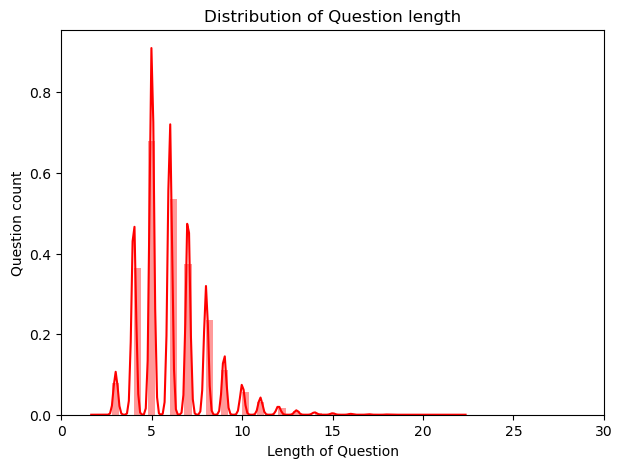

In [34]:
# list of lengths of question token
clQuestionTokenLength = [len(clToken) for clToken in clQuestionTrainValTokenized + clQuestionTestTokenized]
# Create a new figure
plt.figure(figsize=(7,5))
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(clQuestionTokenLength, color='red')
# Set a title for the figure
plt.title('Distribution of Question length')
# Set the label for the x-axis
plt.xlabel('Length of Question')
# Set the label for the y-axis
plt.ylabel('Question count')
# Set the x-axis limits
plt.xlim(0, 30)
# Display the figure
plt.show()

In [35]:
for iC in range(0, 11):
    # Compute the q-th percentile of the token length
    print(10 * iC,'percentile value is', np.percentile(clQuestionTokenLength, 10 * iC))

0 percentile value is 2.0
10 percentile value is 4.0
20 percentile value is 5.0
30 percentile value is 5.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 6.0
70 percentile value is 7.0
80 percentile value is 7.0
90 percentile value is 8.0
100 percentile value is 22.0


In [36]:
for iC in range(0,11):
    # Compute the q-th percentile of the token length
    print(90 + iC,'percentile value is', np.percentile(clQuestionTokenLength, 90 + iC))

90 percentile value is 8.0
91 percentile value is 9.0
92 percentile value is 9.0
93 percentile value is 9.0
94 percentile value is 9.0
95 percentile value is 9.0
96 percentile value is 10.0
97 percentile value is 10.0
98 percentile value is 11.0
99 percentile value is 12.0
100 percentile value is 22.0


In [37]:
# maximum question length
MAX_QUESTION_LENGTH = 22

In [38]:
# Pad training + validation question tokenizations to the same length
caQuestionTrainValTokenized = sequence.pad_sequences(clQuestionTrainValTokenized, maxlen=MAX_QUESTION_LENGTH, padding='post')

# Pad test question tokenizations to the same length
caQuestionTestTokenized = sequence.pad_sequences(clQuestionTestTokenized, maxlen=MAX_QUESTION_LENGTH, padding='post')

In [39]:
# Display the first 10 padding question tokenizations
caQuestionTrainValTokenized[:10]

array([[   3,    2,    5,   26,   74,   94,  444,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,  611,    2,    5,   14,   58,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   12,    2,    1,  322,   53,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    5,   14,    7,  368,  361,  222,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   12,    2,    1,  195,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,    1,   25,   31,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   12,    2,    1, 1102, 6228,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [40]:
# save training + validation question tokenizations to disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost_train_val.pkl', mode='wb') as f:
    joblib.dump(caQuestionTrainValTokenized, f)
    
# save test question tokenizations to disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost_test.pkl', mode='wb') as f:
    joblib.dump(caQuestionTestTokenized, f)

In [41]:
# load training + validation question tokenizations from disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost_train_val.pkl', mode='rb') as f:
    caQuestionTrainValTokenized = joblib.load(f)

# load test question tokenizations from disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost_test.pkl', mode='rb') as f:
    caQuestionTestTokenized = joblib.load(f)

## Answers

In [42]:
# Encode target answers with value between 0 and n_classes-1
oAnswerEncoder = preprocessing.LabelEncoder()
# Fit answer encoder
oAnswerEncoder.fit(clAnswerTrainVal)

LabelEncoder()

In [43]:
# Number of target answers
len(oAnswerEncoder.classes_)

1000

In [44]:
# save answer encoder to disk
with open(f'{DATA_FOLDER}/AnswerEncoderTrainVal.pkl', 'wb') as f:
    joblib.dump(oAnswerEncoder, f)

In [45]:
# load answer encoder from disk
with open(f'{DATA_FOLDER}/AnswerEncoderTrainVal.pkl', 'rb') as f:
    oAnswerEncoder = joblib.load(f)